<a href="https://colab.research.google.com/github/Anish7-anish/BTEC-State-Detection/blob/main/BTEC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from datetime import datetime, timedelta
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import seaborn as sns
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

def get_bearer_token(auth, password, name, role, url):
    # Form and send the GraphQL request for authentication
    auth_query = f"""
        mutation authRequest {{
            authenticationRequest(
                input: {{authenticator: "{auth}", role: "{role}", userName: "{name}"}}
            ) {{
                jwtRequest {{
                    challenge, message
                }}
            }}
        }}
    """
    auth_response = requests.post(url, json={'query': auth_query})
    auth_response.raise_for_status()
    jwt_request = auth_response.json()['data']['authenticationRequest']['jwtRequest']
    if jwt_request['challenge'] is None:
        raise requests.exceptions.HTTPError(jwt_request['message'])

    # Form and send the GraphQL request for the token validation
    validation_query = f"""
        mutation authValidation {{
            authenticationValidation(
                input: {{authenticator: "{auth}", signedChallenge: "{jwt_request['challenge']}|{password}"}}
            ) {{
                jwtClaim
            }}
        }}
    """
    validation_response = requests.post(url, json={'query': validation_query})
    validation_response.raise_for_status()
    jwt_claim = validation_response.json()['data']['authenticationValidation']['jwtClaim']
    return f"Bearer {jwt_claim}"

# Function to perform GraphQL request
def perform_graphql_request(query, url, auth, password, name, role, current_token=None):
    # If no token was provided or if the token is expired, get a new one
    if current_token is None:
        current_token = get_bearer_token(auth, password, name, role, url)
    headers = {"Authorization": current_token}

    # Perform the request with the token
    response = requests.post(url, json={'query': query}, headers=headers)
    if response.status_code == 401:  # Unauthorized, token has expired
        current_token = get_bearer_token(auth, password, name, role, url)
        headers = {"Authorization": current_token}
        response = requests.post(url, json={'query': query}, headers=headers)

    response.raise_for_status()  # Raises an HTTPError for bad responses
    return response.json()

# Your authenticator credentials and endpoint
authenticator = "Anish"
password = "Msdhoni#7ncsu"
name = "atoorpu"
role = "ncsu_group"
instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"

# Your GraphQL query
graphql_query = """
query HistoryQuery {
    getRawHistoryDataWithSampling(
        maxSamples: 0
        ids: ["764692","764782"]
        startTime: "2023-10-03 00:00:00+00"
        endTime: "2023-10-10 00:12:00+00"
    ) {
        ts
        floatvalue
        stringvalue
    }
}
"""

# Perform GraphQL request with dynamic authentication
response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)

# Extract data from response
data = response_data["data"]["getRawHistoryDataWithSampling"]

# Preprocess the queried data
stringvalue_dict = {}
prev_stringvalue = None

for entry in data:
    ts = datetime.fromisoformat(entry["ts"])
    level_pv = entry["floatvalue"]  # Rename "floatvalue" to "Level_PV"
    ro_skid_running = entry["stringvalue"]  # Rename "stringvalue" to "RO_Skid_Running"
    if ro_skid_running is None:
        # Check if there's a previous RO_Skid_Running within 10 minutes
        last_ts = max(stringvalue_dict.keys()) if stringvalue_dict else None
        if last_ts and (ts - last_ts) <= timedelta(minutes=10):
            ro_skid_running = prev_stringvalue
    else:
        prev_stringvalue = ro_skid_running
    stringvalue_dict[ts] = {'Level_PV': level_pv, 'RO_Skid_Running': ro_skid_running}

print("Data")
print(data)
import math






In [2]:

import numpy as np


import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def preprocess_realtime_data(data, sequence_length):
    # Convert string values to 'Off' and 'On'
    for ts, entry in data.items():
        if entry["RO_Skid_Running"] == "0":
            entry["RO_Skid_Running"] = "Off"
        elif entry["RO_Skid_Running"] == "1":
            entry["RO_Skid_Running"] = "On"

    # Convert 'None' or NaN values to np.nan for calculation
    for ts, entry in data.items():
        if entry["Level_PV"] is None or np.isnan(entry.get("Level_PV", np.nan)):
            entry["Level_PV"] = np.nan

    # Convert data to DataFrame for better visualization
    df = pd.DataFrame.from_dict(data, orient='index')

    # Forward fill the missing values for "Level_PV"
    df['Level_PV'] = df['Level_PV'].fillna(method='ffill')

    # After forward fill, if there are still NaNs at the start, fill with the first non-NaN value
    df['Level_PV'].fillna(method='bfill', inplace=True)

    # Create sequences of the same length as model input sequence length
    X_realtime = []
    timestamps = list(df.index)  # Keep track of timestamps to maintain the integrity of sequences

    for i in range(len(df) - sequence_length + 1):
        sequence = [df['Level_PV'].iloc[j] for j in range(i, i + sequence_length)]
        X_realtime.append(sequence)

    return np.array(X_realtime), df



sequence_length = 5
X_realtime,pre_df = preprocess_realtime_data(stringvalue_dict, sequence_length)
print(pre_df)


                                  Level_PV RO_Skid_Running
2023-10-02 23:50:10.005004+00:00  74.26250             Off
2023-10-02 23:54:51.764007+00:00  74.26250             Off
2023-10-03 00:00:10.005004+00:00  74.26250             Off
2023-10-03 00:01:55.763000+00:00  74.06875             Off
2023-10-03 00:02:17.763000+00:00  73.17500             Off
...                                    ...             ...
2023-10-10 00:10:10.005004+00:00  79.33750             Off
2023-10-10 00:10:31.264999+00:00  79.33750             Off
2023-10-10 00:10:37.266006+00:00  79.35000             Off
2023-10-10 00:12:17.264999+00:00  79.34375             Off
2023-10-10 00:20:10.005004+00:00  79.34375             Off

[9826 rows x 2 columns]


In [ ]:
# Load and preprocess the data from the CSV file
data = pd.read_csv('/content/data_minute.csv',header=0)
data = data.dropna()
df = pd.DataFrame(data, columns=['TimeStamp', 'Level_PV', 'RO_Skid_Running'])  # Adjust column names as per your dataset
print(df)
print(data)

# Define the sequence length for the time series data

# Create input sequences and corresponding target values
X = [df['Level_PV'].values[i:i + sequence_length] for i in range(len(df) - sequence_length)]
X = np.array(X)
switch_states = df['RO_Skid_Running'].values[sequence_length - 1:]

# Split the data into training and testing sets
X_train, X_test, switch_states_train, switch_states_test = train_test_split(
    X, switch_states[:-1], test_size=0.2, shuffle=False
)

# Build the autoencoder model using Keras Sequential API
model = Sequential([
    InputLayer(input_shape=(sequence_length, 1)),
    LSTM(50, activation='relu'),
    RepeatVector(sequence_length),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])


# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data
model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))

In [4]:
predictions = model.predict(X_realtime)

# Reshape predictions to match the shape of X_realtime
predictions = predictions.squeeze(axis=-1)
print(predictions)


307/307 [==============================] - 2s 4ms/step
[[74.31589  74.30527  74.29557  74.07794  73.32263 ]
 [74.30452  74.28595  74.10773  73.21724  72.59211 ]
 [74.30745  74.08928  73.21968  72.58026  73.48108 ]
 ...
 [79.43217  79.40962  79.35797  79.37872  79.45894 ]
 [79.397835 79.40797  79.35846  79.38861  79.45216 ]
 [79.39767  79.40874  79.370316 79.38414  79.45215 ]]


In [5]:
switch_states_realtime = np.array([entry['RO_Skid_Running'] for entry in stringvalue_dict.values()][sequence_length - 1:])
print(switch_states_realtime)

['Off' 'Off' 'Off' ... 'Off' 'Off' 'Off']


In [6]:
reconstruction_errors_realtime = np.mean(np.square(X_realtime - predictions), axis=1)
print(reconstruction_errors_realtime)

[0.00553051 0.00590461 0.00721436 ... 0.00449114 0.00445789 0.00449782]


In [7]:
level_pv_last_values = [sequence[-1] for sequence in X_realtime]

off_state_errors_adjusted = reconstruction_errors_realtime[(switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85)]

threshold_realtime_adjusted = np.percentile(off_state_errors_adjusted, 97)
print(threshold_realtime_adjusted)

0.04042745091102849


In [8]:
anomalies_realtime_adjusted = np.where((reconstruction_errors_realtime > threshold_realtime_adjusted) & (switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85))[0]
print(anomalies_realtime_adjusted)

[ 316  564  565  566  567  758  760  788  789  791  814  817  818  820
  847  848  850  863  871  885  886  888  966 1024 1052 1055 1069 1074
 1077 1166 1198 1222 1224 1225 1248 1249 1250 1251 1266 1267 1268 1293
 1294 1295 1296 1432 1434 1698 1700 1946 1947 1948 2191 2352 2353 2355
 2360 2362 2403 2411 2465 2467 2470 2480 2485 2491 2511 2512 2514 2515
 2531 2532 2534 2606 2609 2612 2627 2637 2660 2688 2689 2691 2698 2699
 2701 2709 2710 2745 2756 2759 2765 2767 2778 2863 3008 3009 3013 3015
 3016 3056 3059 3152 3280 3282 3514 3516 4017 4019 4144 4145 4146 4147
 4163 4165 4215 4216 4218 4230 4231 4233 4260 4261 4263 4277 4281 4283
 4353 4371 4412 4430 4450 4452 4476 4602 4604 4614 4655 4656 4657 4658
 4672 4673 4675 4678 4707 4729 4964 4977 5230 5483 5710 5712 5751 5770
 5805 5821 5822 5824 5851 5852 5853 5854 5865 5868 5869 5871 5892 5894
 5895 5897 5970 5980 5982 5993 6043 6044 6046 6055 6058 6074 6076 6109
 6110 6117 6147 6148 6156 6161 6170 6172 6188 6190 6191 6227 6229 6242
 6257 

In [9]:
def filter_anomalies(anomalies, window=2):
    # Create an array to hold the filtered anomalies
    filtered_anomalies = []
    for index in anomalies:
        # Check if the next `window` points are also anomalies
        if all(i in anomalies for i in range(index, index + window)):
            filtered_anomalies.append(index)

    # Return the unique values to avoid duplicate indices
    return np.unique(filtered_anomalies)

# Filter the anomalies
filtered_anomalies_realtime_adjusted = filter_anomalies(anomalies_realtime_adjusted)

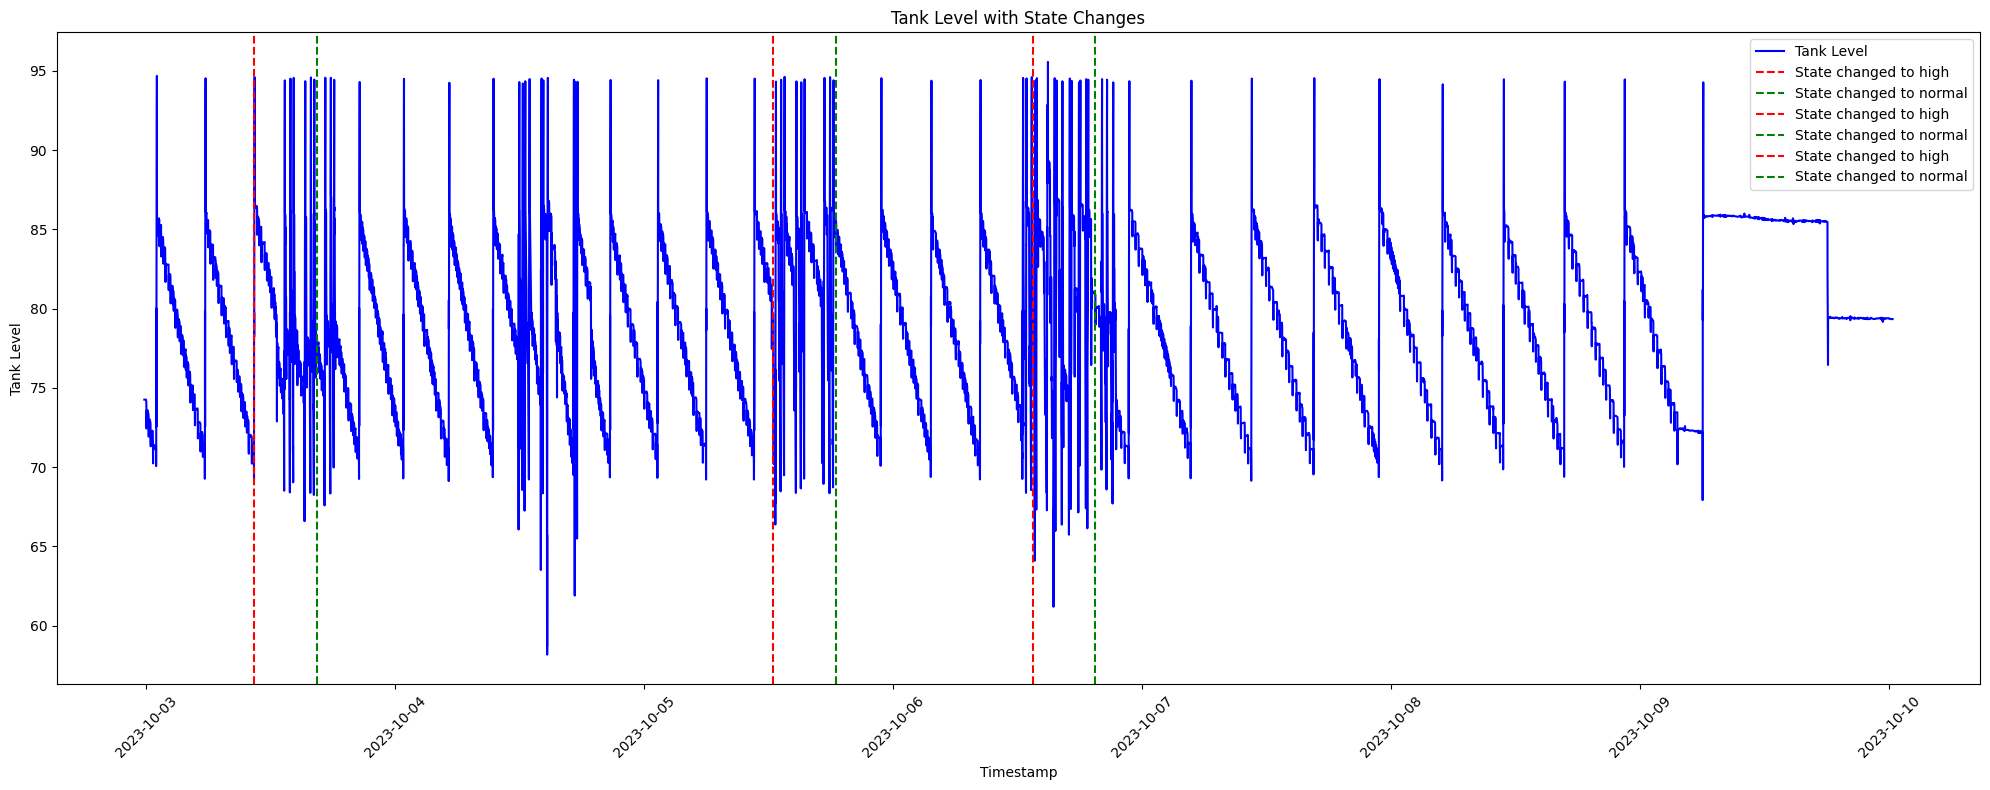

Total state changes: 6
State changed to high at 2023-10-03 10:24:34.764007+00:00
State changed to normal at 2023-10-03 16:26:43.515014+00:00
State changed to high at 2023-10-05 12:26:48.016006+00:00
State changed to normal at 2023-10-05 18:27:22.764007+00:00
State changed to high at 2023-10-06 13:26:44.765014+00:00
State changed to normal at 2023-10-06 19:29:53.264999+00:00


In [10]:
anomaly_presence_threshold = 3  # Number of consecutive anomalies to consider a state change
cooldown_period = timedelta(hours=6)  # Cooldown period after a state change
persistence_requirement = timedelta(hours=6)  # Anomalies must persist for at least this duration

# Initialize variables for state monitoring
current_state = "normal"
last_state_change_time = pre_df.index[0]
state_changes = []

# Process anomalies and determine state changes
current_anomaly_sequence = 0
for i in range(len(pre_df)):
    is_anomaly = i in filtered_anomalies_realtime_adjusted
    time_since_last_change = pre_df.index[i] - last_state_change_time

    if is_anomaly:
        current_anomaly_sequence += 1
    else:
        current_anomaly_sequence = 0

    if current_anomaly_sequence >= anomaly_presence_threshold:
        if current_state == "normal" and time_since_last_change >= cooldown_period:
            current_state = "high"
            last_state_change_time = pre_df.index[i]
            state_changes.append((last_state_change_time, current_state))
            current_anomaly_sequence = 0  # Reset anomaly count after state change

    if not is_anomaly and current_state == "high" and time_since_last_change >= persistence_requirement:
        current_state = "normal"
        last_state_change_time = pre_df.index[i]
        state_changes.append((last_state_change_time, current_state))

# Plotting the results
plt.figure(figsize=(20, 8))
plt.plot(pre_df.index, pre_df['Level_PV'], label='Tank Level', color='blue')
for change_time, state in state_changes:
    plt.axvline(x=change_time, color='red' if state == "high" else 'green', linestyle='--', label=f'State changed to {state}')
plt.title('Tank Level with State Changes')
plt.xlabel('Timestamp')
plt.ylabel('Tank Level')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the number of state changes
print(f"Total state changes: {len(state_changes)}")
for change_time, state in state_changes:
    print(f"State changed to {state} at {change_time}")

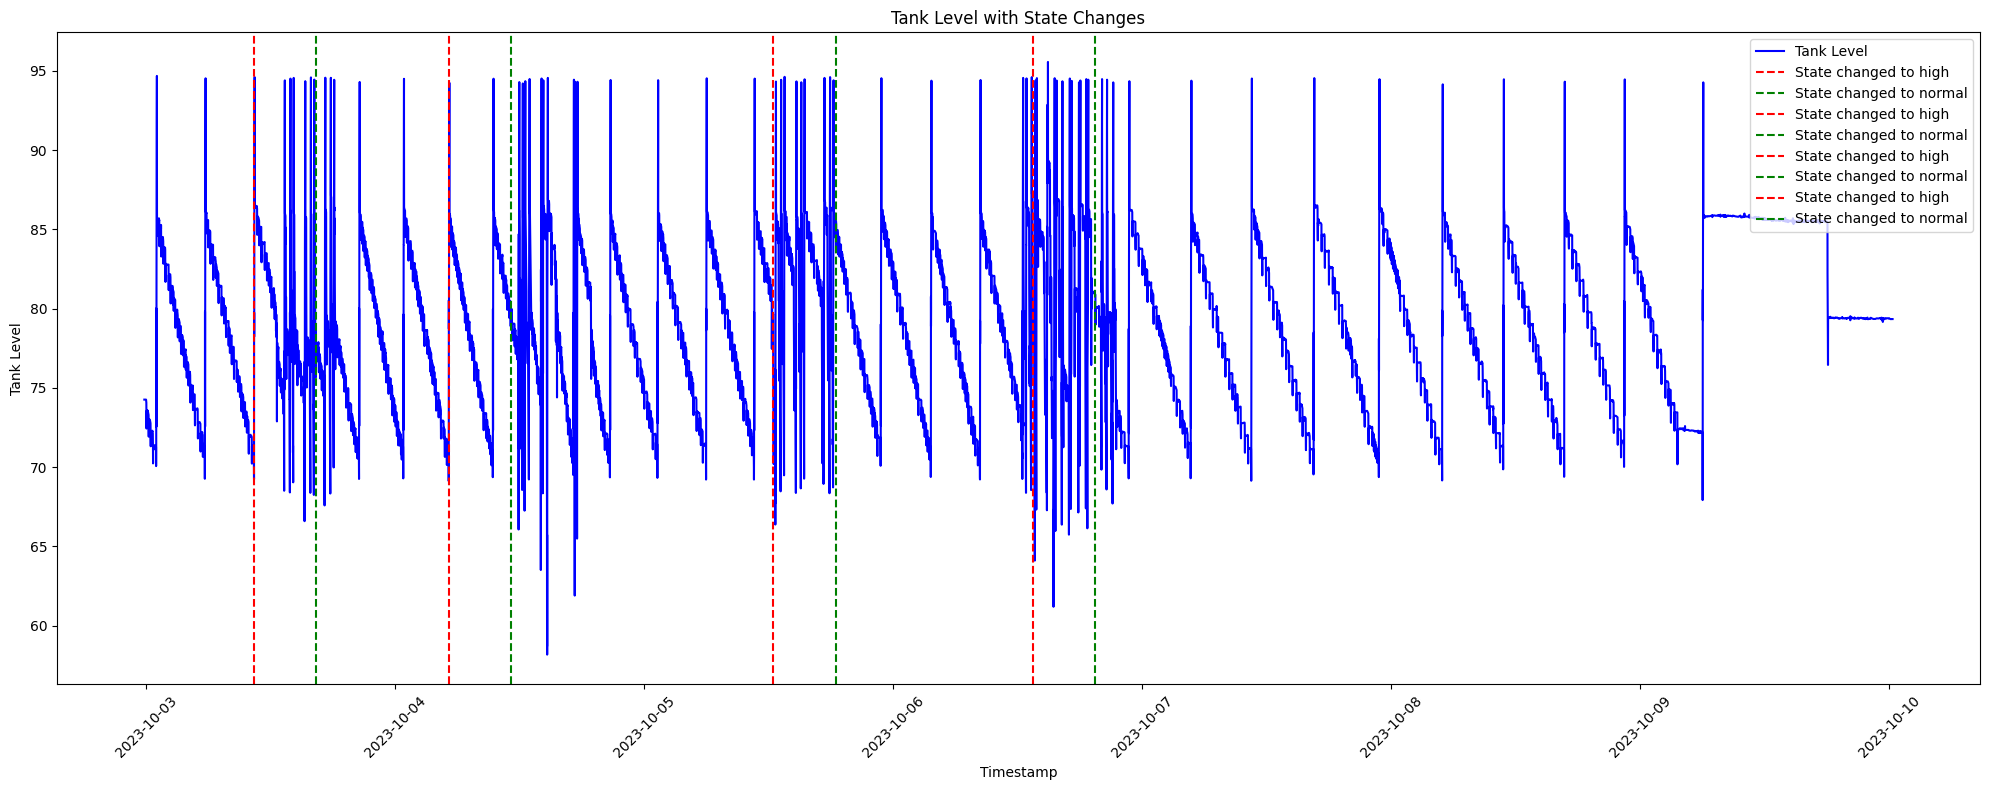

Total state changes: 8
State changed to high at 2023-10-03 10:24:02.764999+00:00
State changed to normal at 2023-10-03 16:24:15.514007+00:00
State changed to high at 2023-10-04 05:10:38.764999+00:00
State changed to normal at 2023-10-04 11:10:47.515014+00:00
State changed to high at 2023-10-05 12:26:40.015014+00:00
State changed to normal at 2023-10-05 18:27:22.764007+00:00
State changed to high at 2023-10-06 13:26:36.765014+00:00
State changed to normal at 2023-10-06 19:29:53.264999+00:00


In [11]:
anomaly_presence_threshold = 2  # Number of consecutive anomalies to consider a state change
cooldown_period = timedelta(hours=6)  # Cooldown period after a state change
persistence_requirement = timedelta(hours=6)  # Anomalies must persist for at least this duration

# Initialize variables for state monitoring
current_state = "normal"
last_state_change_time = pre_df.index[0]
state_changes = []

# Process anomalies and determine state changes
current_anomaly_sequence = 0
for i in range(len(pre_df)):
    is_anomaly = i in filtered_anomalies_realtime_adjusted
    time_since_last_change = pre_df.index[i] - last_state_change_time

    if is_anomaly:
        current_anomaly_sequence += 1
    else:
        current_anomaly_sequence = 0

    if current_anomaly_sequence >= anomaly_presence_threshold:
        if current_state == "normal" and time_since_last_change >= cooldown_period:
            current_state = "high"
            last_state_change_time = pre_df.index[i]
            state_changes.append((last_state_change_time, current_state))
            current_anomaly_sequence = 0  # Reset anomaly count after state change

    if not is_anomaly and current_state == "high" and time_since_last_change >= persistence_requirement:
        current_state = "normal"
        last_state_change_time = pre_df.index[i]
        state_changes.append((last_state_change_time, current_state))

# Plotting the results
plt.figure(figsize=(20, 8))
plt.plot(pre_df.index, pre_df['Level_PV'], label='Tank Level', color='blue')
for change_time, state in state_changes:
    plt.axvline(x=change_time, color='red' if state == "high" else 'green', linestyle='--', label=f'State changed to {state}')
plt.title('Tank Level with State Changes')
plt.xlabel('Timestamp')
plt.ylabel('Tank Level')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the number of state changes
print(f"Total state changes: {len(state_changes)}")
for change_time, state in state_changes:
    print(f"State changed to {state} at {change_time}")

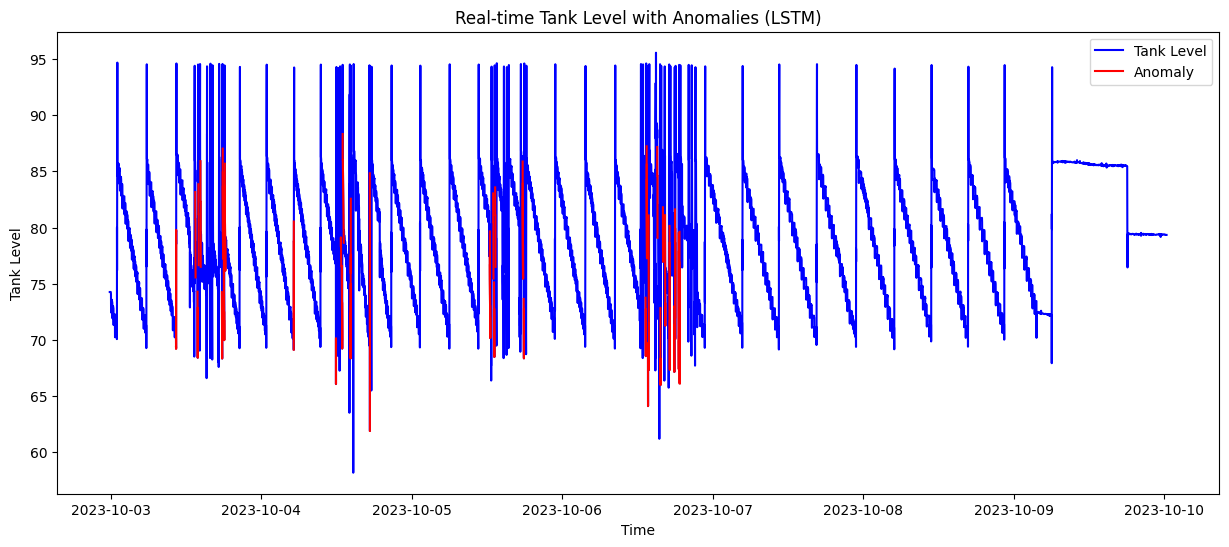

In [12]:
plt.figure(figsize=(15, 6))

# Plot the tank level
plt.plot(pre_df.index, pre_df['Level_PV'], label='Tank Level', color='blue')

# Plot the anomalies using plt.plot
for anomaly in filtered_anomalies_realtime_adjusted:
    anomaly_start_index = anomaly
    anomaly_end_index = anomaly + sequence_length
    # Plot the segment of the anomaly
    plt.plot(pre_df.index[anomaly_start_index:anomaly_end_index],
             pre_df['Level_PV'][anomaly_start_index:anomaly_end_index],
             'r-', label='Anomaly' if 'Anomaly' not in [l.get_label() for l in plt.gca().get_lines()] else "")

plt.legend()
plt.title('Real-time Tank Level with Anomalies (LSTM)')
plt.xlabel('Time')
plt.ylabel('Tank Level')
plt.show()


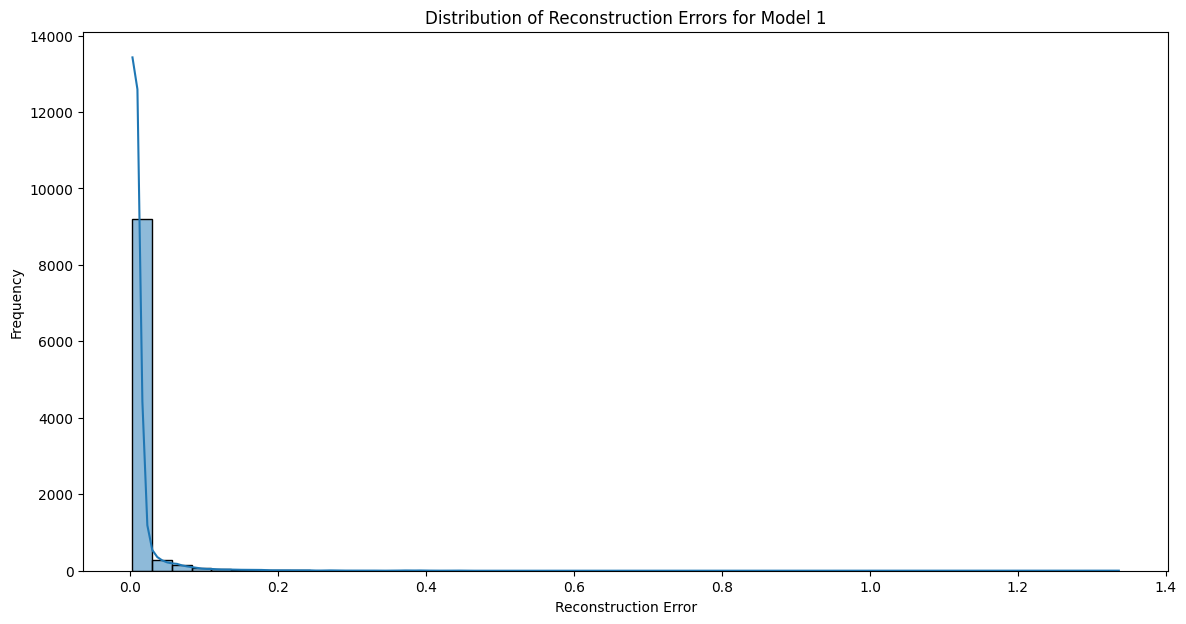

In [13]:
plt.figure(figsize=(14, 7))
sns.histplot(reconstruction_errors_realtime, bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors for Model 1')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()